# Walmart : Triptype Classification

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Objective : 
> ### 각 고객의 구매정보에 따른 구매 건의 Type을 분류

### (2) Data : 
### train : 647054 rows, 7 columns
| Index 	| Feature               	| Description                                  	|
|-------	|-----------------------	|----------------------------------------------	|
| 1     	| TripType              	| Target                                       	|
| 2     	| VisitNumber           	| 각 손님의 Index                              	|
| 3     	| Weekday               	| VisitNumber가 발생한 요일                    	|
| 4     	| Upc                   	| 구매한 제품의 고유한 바코드                  	|
| 5     	| ScanCount             	| 구매 수량 ( 반품 시 `-` 값으로 표기 )        	|
| 6     	| DepartmentDescription 	| 제품의 대분류                                	|
| 7     	| FinelineNumber        	| 월마트 자체적으로 정의 한 제품의 소분류 코드 	|

(3) _UPC code description_
- Check Digit : 숫자가 정확하게 구성되어 있는가를 보장해주는 컴퓨터 검증 숫자. UPC의 신뢰도를 검증

<img src="data/upc.png">



<br>

### test : 653646 rows, 6 columns
- TripType을 제외한 동일한 컬럼


<br>

### (3) Evaluation : 
> ### Multi-class log loss
> $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

# [ Result ]: 
> #### - 참가 팀 : 총 1047 팀 
> #### - 최종 점수 : 0.795
> #### - 캐글 등수 : 295등 (상위 28%)


# [ Approach ]:
> #### - 주어진 컬럼을 통한 Feature Engineering
    - Parsing Information (UPC, ScanCount)
    - Feature Encoding
    - Dummy Variables
    - Statistic
    
> #### - XGBoost

* * * *

In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from walmart_utils import *

In [29]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# [ EDA ]

In [17]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


## Train Data

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


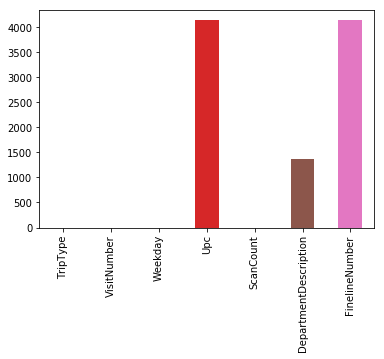

In [14]:
train.isnull().sum().plot(kind='bar')

In [15]:
pd.crosstab(index=train['DepartmentDescription'], columns=train['TripType']).idxmax()

TripType
3               FINANCIAL SERVICES
4                     PHARMACY OTC
5                     PHARMACY OTC
6                 LIQUOR,WINE,BEER
7                     SERVICE DELI
8                      DSD GROCERY
9                        MENS WEAR
12                     DSD GROCERY
14              FABRICS AND CRAFTS
15                     CELEBRATION
18                            TOYS
19                     ELECTRONICS
20                      AUTOMOTIVE
21              FABRICS AND CRAFTS
22                     ELECTRONICS
23         PLAYERS AND ELECTRONICS
24                   COOK AND DINE
25                       MENS WEAR
26                        HARDWARE
27                 LAWN AND GARDEN
28                  SPORTING GOODS
29                            TOYS
30                           SHOES
31                        WIRELESS
32     INFANT CONSUMABLE HARDLINES
33        HOUSEHOLD CHEMICALS/SUPP
34               PETS AND SUPPLIES
35                     DSD GROCERY
36         

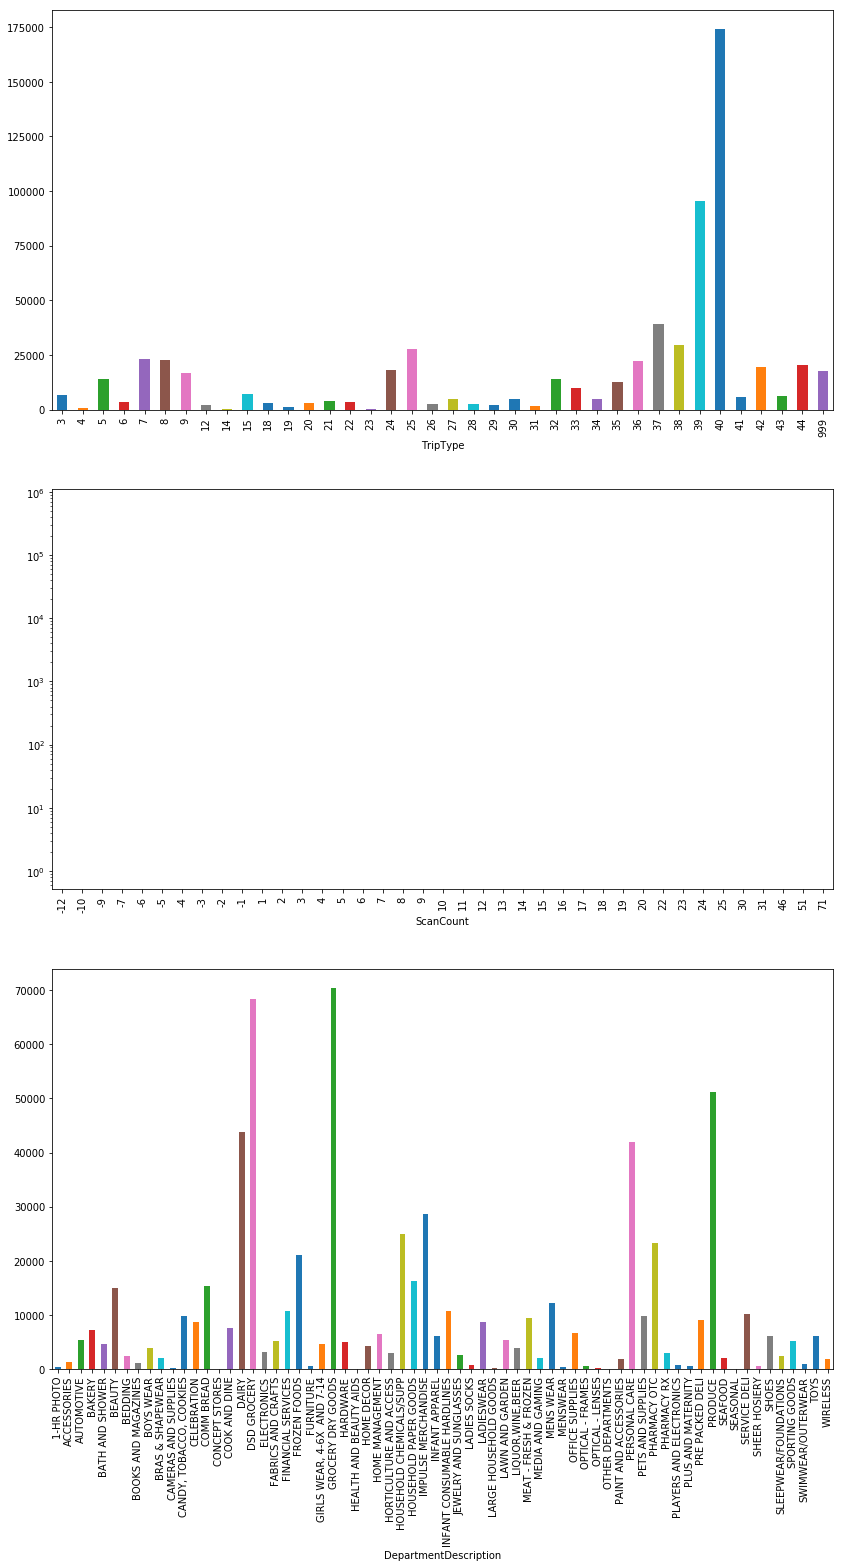

In [25]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(14, 25))

# Plot total number of TripTypes
ax1 = fig.add_subplot(311)
train.groupby(['TripType'], as_index=False).size().plot('bar')

# Plot total number of ScanCounts    ## 이거 왜 이러죠 ㅠㅜㅠㅜㅠㅜㅠㅜㅠㅜㅜㅠㅜㅠㅜㅠㅜㅠㅜㅠㅜㅠㅜ
ax2 = fig.add_subplot(312)
train.groupby(['ScanCount'], as_index=False).size().plot('bar', logy=True)

# Plot total number of DepartmentDescriptions
ax3 = fig.add_subplot(313)
train.groupby(['DepartmentDescription'], as_index=False).size().plot('bar')

plt.show()

In [26]:
plt.figure(figsize=(30, 500))

for idx, i in enumerate(list(train['TripType'].unique())):
    
    
    plt.subplot(19, 2, idx+1)
    triptype_each = train[train['TripType'].isin([i])]
    sns.countplot(y='DepartmentDescription', data=triptype_each)

plt.show()

# [ Preprocessing ]

### UPC company code 분리

In [31]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

In [32]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,681131
1,30,7,Friday,60538815980,1,SHOES,8931.0,605388
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,741081
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661


### Return 발생 여부 표기

In [33]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [34]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0
1,30,7,Friday,60538815980,1,SHOES,8931.0,605388,0.0
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,741081,0.0
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0


### Weekday 인코딩

In [35]:
wd = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
      "Friday": 4, "Saturday": 5, "Sunday": 6}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

In [36]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0


### 실제 판매 수량

In [37]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [38]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2


### 반품 수량

In [39]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [40]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0,-1
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1,0
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1,0
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2,0
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2,0


### UPC Check Digit 추가

In [41]:
train["check"] = train.Upc.apply(check_digit)
test["check"] = test.Upc.apply(check_digit)

In [42]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum,check
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0,-1,7
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1,0,9
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1,0,2
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2,0,2
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2,0,1


# [ Feature Engineering ]

### VisitNumber 별 가장 빈도가 잦은 FinelineNumber

In [43]:
# new feature

train_fineline = train[["VisitNumber", "FinelineNumber"]]
test_fineline = test[["VisitNumber", "FinelineNumber"]]

train_fineline = train_fineline.groupby("VisitNumber", as_index=False).agg(mode)
train_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

test_fineline = test_fineline.groupby("VisitNumber", as_index=False).agg(mode)
test_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

In [44]:
train_fineline.head()

,VisitNumber,MF_FinelineNumber
0,5,1000.0
1,7,8931.0
2,8,3565.0
3,9,115.0
4,10,2008.0


### VisitNumber 별 

In [45]:
train_upc_fine = train[["VisitNumber", "Upc", "FinelineNumber"]]
test_upc_fine = test[["VisitNumber", "Upc", "FinelineNumber"]]

train_upc_fine_group = train_upc_fine.groupby("VisitNumber", as_index=False).count()
train_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                     "FinelineNumber": "N_FinelineNumber"}, inplace=True)
test_upc_fine_group = test_upc_fine.groupby("VisitNumber", as_index=False).count()
test_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                    "FinelineNumber": "N_FinelineNumber"}, inplace=True)

In [46]:
train_upc_fine_group.head()

,VisitNumber,N_Upc,N_FinelineNumber
0,5,1,1
1,7,2,2
2,8,23,22
3,9,3,3
4,10,3,3


In [47]:
train = train.drop(["Upc", "FinelineNumber"], axis=1)
test = test.drop(["Upc", "FinelineNumber"], axis=1)

### DepartmentDescription의 더미변수 생성

In [48]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()

In [49]:
train_dd.head()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 각 VisitNumber별 가장 많이 구매한 제품의 기업 코드

In [50]:
train_company = train[["VisitNumber", "company"]]
test_company = test[["VisitNumber", "company"]]

train_company = train_company.groupby("VisitNumber", as_index=False).agg(mode)
test_company = test_company.groupby("VisitNumber", as_index=False).agg(mode)

In [51]:
train_company.head()

,VisitNumber,company
0,5,681131
1,7,605388
2,8,223840
3,9,107008
4,10,641441


### 각 VisitNumber 별 가장 많이 구매한 제품의 Check Digit

In [52]:
train_check = train[["VisitNumber", "check"]]
test_check = test[["VisitNumber", "check"]]

train_check = train_check.groupby("VisitNumber", as_index=False).agg(mode)
test_check = test_check.groupby("VisitNumber", as_index=False).agg(mode)

In [53]:
train_check.head()

,VisitNumber,check
0,5,7
1,7,9
2,8,5
3,9,4
4,10,8


### VisitNumber를 index로 하는 groupby & merge

In [54]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train_by_max = train[["TripType", "VisitNumber", "Weekday", "Return"]]
test_by_max = test[["VisitNumber", "Weekday", "Return"]]

train_by_max = train_by_max.groupby("VisitNumber", as_index=False).max()
test_by_max = test_by_max.groupby("VisitNumber", as_index=False).max()

In [55]:
train = train_by_sum.merge(train_by_max, on=["VisitNumber"])
train = train.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_company, on=["VisitNumber"])
train = train.merge(train_check, on=["VisitNumber"])
train = train.merge(train_fineline, on=["VisitNumber"])
train = train.merge(train_upc_fine_group, on=["VisitNumber"])

test = test_by_sum.merge(test_by_max, on=["VisitNumber"])
test = test.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_company, on=["VisitNumber"])
test = test.merge(test_check, on=["VisitNumber"])
test = test.merge(test_fineline, on=["VisitNumber"])
test = test.merge(test_upc_fine_group, on=["VisitNumber"])

In [56]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,TripType,Weekday,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,check,MF_FinelineNumber,N_Upc,N_FinelineNumber
0,5,-1,0,-1,999,4,1.0,0,0,0,...,0,0,0,0,0,681131,7,1000.0,1,1
1,7,2,2,0,30,4,0.0,0,0,0,...,0,0,0,0,0,605388,9,8931.0,2,2
2,8,28,30,-2,26,4,1.0,0,0,0,...,0,0,0,0,0,223840,5,3565.0,23,22
3,9,3,3,0,8,4,0.0,0,0,0,...,0,0,0,0,0,107008,4,115.0,3,3
4,10,3,3,0,8,4,0.0,0,0,0,...,0,0,0,0,0,641441,8,2008.0,3,3


- ### test data에서는 발생하지 않는 DepartmentDescription 제거
- ### train & target 분리

In [57]:
y = train["TripType"]
train = train.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)

### 각 VisitNumber 별 판매된 아이템의 DepartmentDescription 빈도

In [58]:
from walmart_utils import category_counts

In [59]:
%%time
train = category_counts(train)
test = category_counts(test)

CPU times: user 22.7 s, sys: 237 ms, total: 23 s
Wall time: 23.5 s


In [60]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,check,MF_FinelineNumber,N_Upc,N_FinelineNumber
0,5,-1,0,-1,4,1.0,1,0,0,0,...,0,0,0,0,0,681131,7,1000.0,1,1
1,7,2,2,0,4,0.0,2,0,0,0,...,0,0,0,0,0,605388,9,8931.0,2,2
2,8,28,30,-2,4,1.0,6,0,0,0,...,0,0,0,0,0,223840,5,3565.0,23,22
3,9,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,0,107008,4,115.0,3,3
4,10,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,0,641441,8,2008.0,3,3


### VisitNumber 별로 발생한 FinelineNumber와 UPC의 비율

In [61]:
train["Upc_Depts"] = train["N_Upc"] / train["N_FinelineNumber"]
test["Upc_Depts"] = test["N_Upc"] / test["N_FinelineNumber"]

In [62]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,check,MF_FinelineNumber,N_Upc,N_FinelineNumber,Upc_Depts
0,5,-1,0,-1,4,1.0,1,0,0,0,...,0,0,0,0,681131,7,1000.0,1,1,1.000000
1,7,2,2,0,4,0.0,2,0,0,0,...,0,0,0,0,605388,9,8931.0,2,2,1.000000
2,8,28,30,-2,4,1.0,6,0,0,0,...,0,0,0,0,223840,5,3565.0,23,22,1.045455
3,9,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,107008,4,115.0,3,3,1.000000
4,10,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,641441,8,2008.0,3,3,1.000000


### Weeday, Return의 더미변수 생성

In [63]:
train = pd.get_dummies(train, columns=["Weekday", "Return"])
test = pd.get_dummies(test, columns=["Weekday", "Return"])

In [64]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,Upc_Depts,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Return_0.0,Return_1.0
0,5,-1,0,-1,1,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,0,1
1,7,2,2,0,2,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,1,0
2,8,28,30,-2,6,0,0,0,0,0,...,1.045455,0,0,0,0,1,0,0,0,1
3,9,3,3,0,2,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,1,0
4,10,3,3,0,2,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,1,0


# [ Model Generation ]

- XGBoost

- # GridSearch ?????

In [65]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [66]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y_labeled, random_state=0)

In [68]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [69]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.25}

evals = [(dtrain, 'train'), (dtest, 'eval')]


bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
               early_stopping_rounds=10,)

[0]	train-mlogloss:2.93473	eval-mlogloss:2.95034
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.34292	eval-mlogloss:2.37604
[2]	train-mlogloss:1.91012	eval-mlogloss:1.96236
[3]	train-mlogloss:1.65288	eval-mlogloss:1.71771
[4]	train-mlogloss:1.47689	eval-mlogloss:1.55134
[5]	train-mlogloss:1.34534	eval-mlogloss:1.4286
[6]	train-mlogloss:1.24263	eval-mlogloss:1.33398
[7]	train-mlogloss:1.1602	eval-mlogloss:1.25944
[8]	train-mlogloss:1.09234	eval-mlogloss:1.1989
[9]	train-mlogloss:1.03427	eval-mlogloss:1.14776
[10]	train-mlogloss:0.98636	eval-mlogloss:1.10616
[11]	train-mlogloss:0.945656	eval-mlogloss:1.07151
[12]	train-mlogloss:0.910154	eval-mlogloss:1.04175
[13]	train-mlogloss:0.879981	eval-mlogloss:1.01726
[14]	train-mlogloss:0.851834	eval-mlogloss:0.994943
[15]	train-mlogloss:0.828369	eval-mlogloss:0.976873
[16]	train-mlogloss:0.807064	eval-mlogloss:0.960246
[17

In [70]:
classes = np.array(list(set(label_enc.inverse_transform(y_labeled))))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [71]:
dmtest = xgb.DMatrix(test.values) 
pred_proba = bst.predict(dmtest)

proba_df = pd.DataFrame(pred_proba, columns=classes)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([test[["VisitNumber"]], proba_df], axis=1)
sub_df.to_csv("data/team_SWYA_submission.csv", index=False)